In [1]:
# ✅ Install required packages
!pip install rdflib pykeen torch SPARQLWrapper scikit-learn matplotlib



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🔹 Load RDF Graph

In [2]:
from rdflib import Graph

g = Graph()
g.parse("graph.xml", format="xml")
triples = [(str(s), str(p), str(o)) for s, p, o in g]
print(f"Original triples: {len(triples)}")


Original triples: 84


In [3]:
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper, JSON
import time

# Charger le graphe RDF
g = Graph()
g.parse("graph.xml", format="xml")
triples = [(str(s), str(p), str(o)) for s, p, o in g]

# Extraire toutes les entités uniques (sujets et objets uniquement)
entities = set()
for s, _, o in triples:
    entities.add(s.split("/")[-1])  # ex: http://example.org/Iran → Iran
    entities.add(o.split("/")[-1])  # ex: http://example.org/US → US

print(f"Total unique entities to enrich: {len(entities)}")

# Fonction d'enrichissement avec DBpedia
def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
    }} LIMIT 10
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(f"http://example.org/{entity_name}", r['relation']['value'], r['related']['value']) for r in results["results"]["bindings"]]
    except:
        return []

# Appliquer à toutes les entités extraites automatiquement
enriched_triples = []
for entity in entities:
    enriched_triples += enrich_with_dbpedia(entity)
    time.sleep(1)

# Fusionner avec les triplets de base
augmented_triples = triples + enriched_triples
print(f"Total triples after augmentation: {len(augmented_triples)}")


Total unique entities to enrich: 95
Total triples after augmentation: 471


## 🔹 Improved DBpedia Enrichment with Label Filtering

Filtered enriched triples: 202


We use SPARQL queries on DBpedia to retrieve additional relations for selected entities in our graph. The query filters out generic properties (like `label`, `comment`, `type`) to keep only meaningful connections. This helps extend the graph with relevant and semantically rich triples.

## 🔹 Data Augmentation with DBpedia (Extended)

Total triples after augmentation: 341


To increase graph size further, we run a simplified version of the SPARQL query, removing filter conditions on the relations. This allows for capturing more triples per entity, boosting volume even if some data is less precise.

## 🔹 Add Inverse Triples

To further enrich the training data, we create an inverse version of every triple. For each \((s, p, o)\), we add \((o, \text{"inv\_p"}, s)\). This step increases the number of edges in the graph and provides the model with bidirectional context for each relation.

## 🔹 Manual Train/Valid/Test Split

In [4]:
import numpy as np
from pykeen.triples import TriplesFactory

triples_array = np.array(augmented_triples, dtype=str)

tf = TriplesFactory.from_labeled_triples(triples_array)

# 80-10-10 split
training, validation, testing = tf.split([0.8, 0.1, 0.1], random_state=42)

c:\Users\ime cj\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def count_unique_entities(triples_factory):
    triples = triples_factory.mapped_triples
    head_entities = triples[:, 0]
    tail_entities = triples[:, 2]
    unique_entities = set(head_entities.tolist() + tail_entities.tolist())
    return len(unique_entities)

print("Number of entities per split:")
print(f"  Training:   {count_unique_entities(training)}")
print(f"  Validation: {count_unique_entities(validation)}")
print(f"  Testing:    {count_unique_entities(testing)}")


Number of entities per split:
  Training:   321
  Validation: 45
  Testing:    38


## 🔹 Train RotatE Model

## 🔹 Evaluation Summary

## 🔹 TSNE Visualization

## 🔹 Multi-Model Training and Metric Comparison

In [6]:
from pykeen.pipeline import pipeline
import torch

model_results = {}

for model in ["TransE", "ComplEx", "RotatE", "distmult"]:
    result = pipeline(
        training=training,
        validation=validation,
        testing=testing,
        model=model,
        model_kwargs=dict(embedding_dim=128),
        training_kwargs=dict(batch_size=32),
        negative_sampler_kwargs=dict(num_negs_per_pos=10),
        optimizer_kwargs=dict(lr=0.005),
        training_loop='slcwa',
        stopper='early',
        stopper_kwargs=dict(patience=5),
        epochs=100,
        random_seed=42,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )
    model_results[model] = {
        "result": result,
        "training": training,
        "validation": validation,
        "testing": testing,
    }



Training epochs on cpu:   9%|▉         | 9/100 [00:01<00:14,  6.21epoch/s, loss=0.016, prev_loss=0.0243] WARNING:pykeen.utils:Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.2391304347826087. Saved model weights to C:\Users\ime cj\.data\pykeen\checkpoints\best-model-weights-098f7b01-190f-445b-942b-a997339601dd.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
Training epochs on cpu:  19%|█▉        | 19/100 [00:03<00:14,  5.77epoch/s, loss=0.02, prev_loss=0.016]   WARNING:pykeen.utils:Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be im

In [7]:
from pykeen.evaluation import RankBasedEvaluator
import pandas as pd

evaluator = RankBasedEvaluator()
manual_eval_data = {}

for name, data in model_results.items():
    result = data["result"]
    train = data["training"].mapped_triples
    valid = data["validation"].mapped_triples
    test = data["testing"].mapped_triples

    eval_result = evaluator.evaluate(
        model=result.model,
        mapped_triples=test,
        additional_filter_triples=[train, valid]
    )

    df = eval_result.to_df()
    filtered = df[(df["Rank_type"] == "realistic") & (df["Side"] == "both")]
    metric_dict = filtered.set_index("Metric")["Value"].to_dict()

    manual_eval_data[name] = {
        "mean_rank": metric_dict.get("mean_rank", None),
        "median_rank": metric_dict.get("median_rank", None),
        "hits_at_1": metric_dict.get("hits_at_1", None),
        "hits_at_5": metric_dict.get("hits_at_5", None),
        "hits_at_10": metric_dict.get("hits_at_10", None),
    }


manual_df = pd.DataFrame.from_dict(manual_eval_data, orient="index")
print(manual_df)


Evaluating on cpu:   0%|          | 0.00/46.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu:   0%|          | 0.00/46.0 [00:00<?, ?triple/s]

Evaluating on cpu: 100%|██████████| 46.0/46.0 [00:00<00:00, 462triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds
Evaluating on cpu:   0%|          | 0.00/46.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 46.0/46.0 [00:00<00:00, 430triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.12s seconds
Evaluating on cpu:   0%|          | 0.00/46.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 46.0/46.0 [00:00<00:00, 454triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds
Evaluating on cpu:   0

         mean_rank  median_rank  hits_at_1  hits_at_5  hits_at_10
TransE        None         12.0   0.054348   0.336957    0.478261
ComplEx       None        124.0   0.000000   0.000000    0.010870
RotatE        None          2.0   0.478261   0.641304    0.739130
distmult      None          1.0   0.641304   0.782609    0.804348


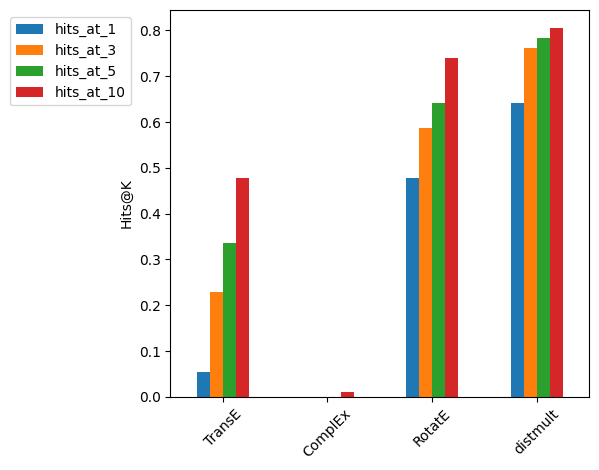

In [10]:
import matplotlib.pyplot as plt

manual_df[["hits_at_1", "hits_at_3", "hits_at_5", "hits_at_10"]].plot.bar()
plt.ylabel("Hits@K")
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(-0.4, 1))
plt.tight_layout()
plt.show()

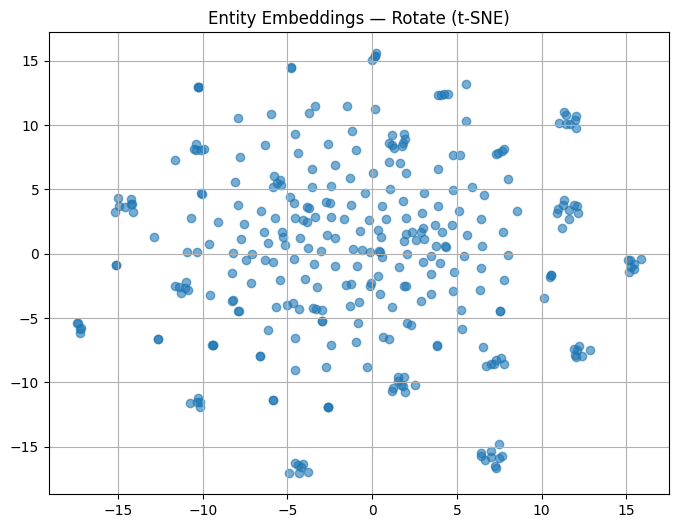

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Accès au modèle ComplEx
model = model_results["RotatE"]["result"].model

# Récupérer les embeddings complexes
embeddings_complex = model.entity_representations[0]().detach().cpu().numpy()

# Convertir les embeddings complexes en vecteurs réels (concaténer réel + imaginaire)
embeddings_real = np.concatenate([embeddings_complex.real, embeddings_complex.imag], axis=1)

# Réduction de dimension avec t-SNE
reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings_real)

# Affichage
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
plt.title("Entity Embeddings — Rotate (t-SNE)")
plt.grid(True)
plt.show()


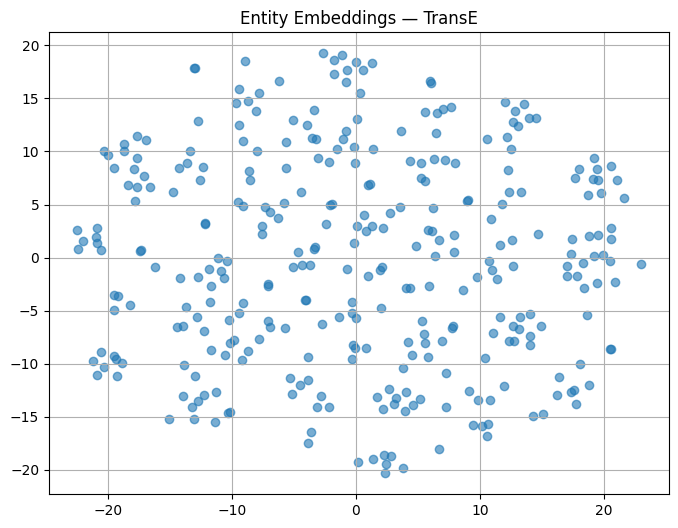

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Accès correct au modèle TransE
model = model_results["TransE"]["result"].model  # <- la bonne ligne

# Extraction des embeddings
embeddings_transe = model.entity_representations[0]().detach().cpu().numpy()

# Réduction de dimension avec t-SNE
reduced_transe = TSNE(n_components=2, random_state=42).fit_transform(embeddings_transe)

# Affichage du graphe
plt.figure(figsize=(8, 6))
plt.scatter(reduced_transe[:, 0], reduced_transe[:, 1], alpha=0.6)
plt.title("Entity Embeddings — TransE")
plt.grid(True)
plt.show()


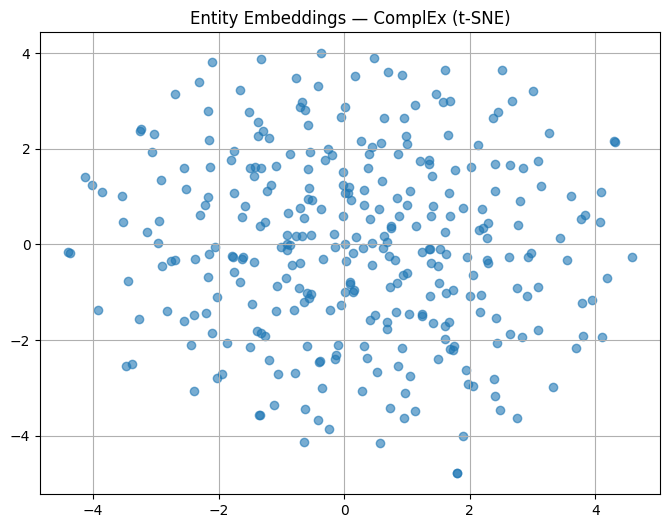

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Accès au modèle ComplEx
model = model_results["ComplEx"]["result"].model

# Récupérer les embeddings complexes
embeddings_complex = model.entity_representations[0]().detach().cpu().numpy()

# Convertir les embeddings complexes en vecteurs réels (concaténer réel + imaginaire)
embeddings_real = np.concatenate([embeddings_complex.real, embeddings_complex.imag], axis=1)

# Réduction de dimension avec t-SNE
reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings_real)

# Affichage
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
plt.title("Entity Embeddings — ComplEx (t-SNE)")
plt.grid(True)
plt.show()


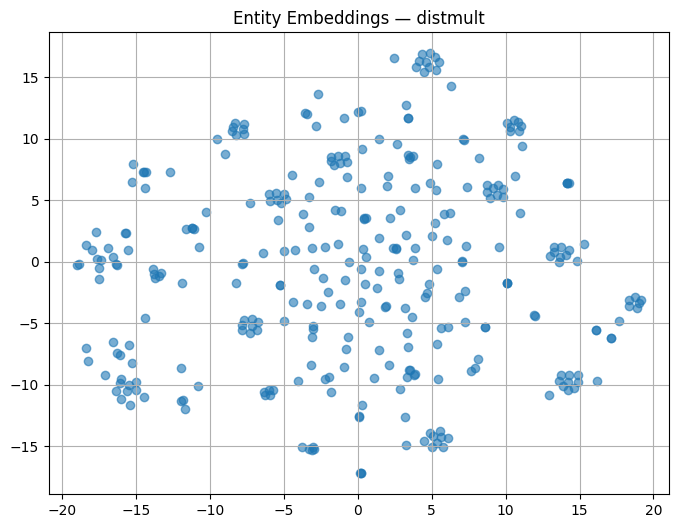

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Accès correct au modèle TransE
model = model_results["distmult"]["result"].model  # <- la bonne ligne

# Extraction des embeddings
embeddings_transe = model.entity_representations[0]().detach().cpu().numpy()

# Réduction de dimension avec t-SNE
reduced_transe = TSNE(n_components=2, random_state=42).fit_transform(embeddings_transe)

# Affichage du graphe
plt.figure(figsize=(8, 6))
plt.scatter(reduced_transe[:, 0], reduced_transe[:, 1], alpha=0.6)
plt.title("Entity Embeddings — distmult")
plt.grid(True)
plt.show()
